In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Data Preprocessing

In [2]:
# read the data
weather = pd.read_csv("weatherAUS.csv", sep = ",")
# get copy of df with NA
weather_na = weather.copy()
# show the first 5 rows
weather.head(5)

# drop the Date variable 
weather = weather.drop("Date", axis = 1)

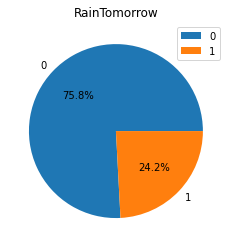

In [3]:
# pie chart of RainTomorrow in original dataset
data = [(weather['RainTomorrow'] == 'No').sum(), (weather['RainTomorrow'] != 'No').sum()]
lab = [0,1]
plt.pie(data, labels = lab, autopct='%1.1f%%')
plt.title('RainTomorrow')
plt.legend()
plt.show()

In [4]:
from sklearn.utils import resample

# balance the dataset
no_data = weather[weather.RainTomorrow == "No"]
yes_data = weather[weather.RainTomorrow == "Yes"]
yes_resamp = resample(yes_data, replace=True, n_samples=len(no_data), random_state=1)
weather = pd.concat([no_data, yes_resamp]).reset_index()
weather = weather.drop("index", axis = 1)

In [5]:
# check the amount of missing values
def missing_values_table(df):
        
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([ mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = { 0 : 'Missing Values', 1 : '% of Total Values'})
        mz_table['Data Type'] = df.dtypes
        
        #sort by missing % of total values
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")

        return mz_table

missing_values_table(weather)

Your selected dataframe has 22 columns and 220632 Rows.
There are 20 columns that have missing values.


,Missing Values,% of Total Values,Data Type
Sunshine,104897,47.5,float64
Evaporation,95260,43.2,float64
Cloud3pm,85379,38.7,float64
Cloud9am,81129,36.8,float64
Pressure3pm,21589,9.8,float64
Pressure9am,21589,9.8,float64
WindGustDir,15414,7.0,object
WindGustSpeed,15286,6.9,float64
WindDir9am,14553,6.6,object
WindDir3pm,6323,2.9,object


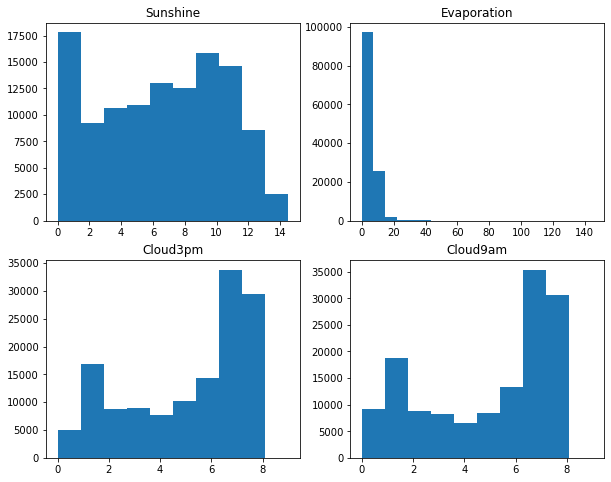

In [6]:
# check distributions of `Sunshine`, `Evaporation`, `Cloud3pm`, `Cloud9am`
fig,ax =  plt.subplots(2,2, figsize=(10, 8))
ax[0][0].hist(weather['Sunshine'].dropna(), bins = 10)
ax[0][0].set_title('Sunshine')

ax[0][1].hist(weather['Evaporation'].dropna(), bins = 20)
ax[0][1].set_title('Evaporation')

ax[1][0].hist(weather['Cloud3pm'].dropna(), bins = 10)
ax[1][0].set_title('Cloud3pm')

ax[1][1].hist(weather['Cloud9am'].dropna(), bins = 10)
ax[1][1].set_title('Cloud9am')
plt.show()


### Process Numerical Variables

In [8]:
# replace the na values in numerical columns with their median
numeric = weather.select_dtypes(include = "float64").columns
scale = StandardScaler()
for col in numeric:
    weather[col].fillna(weather[col].median(), inplace = True)

weather_outliers = weather.copy()
    
for col in ["Rainfall", "Evaporation","WindSpeed9am", "WindSpeed3pm","WindGustSpeed"]:
    IQR = weather[col].quantile(0.75) - weather[col].quantile(0.25)
    LQ = weather[col].quantile(0.25) - IQR*3
    UQ = weather[col].quantile(0.75) + IQR*3
    weather = weather[(weather[col] > LQ)]
    weather = weather[(weather[col] < UQ)]
    

# normalize the numeric columns
weather[numeric] = scale.fit_transform(weather[numeric])

    
# replace the na values in categorical columns with None as a new class   
categoric = weather.select_dtypes(include = "object").drop(["RainToday","RainTomorrow"], axis = 1).columns
for col in categoric:
    weather[col].fillna("None", inplace = True)

# get a copy of df without dummy     
weather_full = weather.copy()
    

### Process Categorical Variables

In [9]:
# replace the categorical variables with dummy variable
for col in categoric:
    temp = pd.get_dummies(weather[col], prefix = col)
    weather = pd.merge(left = weather, right = temp, left_index = True, right_index = True)
    weather = weather.drop(col, axis = 1)

    
# remove na in raintoday and raintomorrow
weather = weather.dropna().copy()


# replace Raintoday and Raintomorrow with dummy variable (0 = No, 1 = Yes)
weather["RainToday"] = pd.get_dummies(weather["RainToday"], drop_first = True)
weather["RainTomorrow"] = pd.get_dummies(weather["RainTomorrow"], drop_first = True)


# show the first 5 rows
weather.head(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_None,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.257316,0.121718,-0.176022,0.095941,0.033668,0.248688,0.700436,0.590147,-0.056158,-1.713874,...,0,0,0,0,0,0,0,0,1,0
1,-0.710903,0.453366,-0.497781,0.095941,0.033668,0.248688,-1.117751,0.364607,-1.642193,-1.566307,...,0,0,0,0,0,0,0,0,0,1
2,0.176631,0.543816,-0.497781,0.095941,0.033668,0.397871,0.586799,0.815687,-1.994645,-1.320361,...,0,0,0,0,0,0,0,0,0,1
3,-0.420438,0.890539,-0.497781,0.095941,0.033668,-1.243140,-0.322294,-1.101401,-1.583451,-2.009009,...,0,0,0,0,0,0,0,0,0,0
4,0.918933,1.538760,0.038484,0.095941,0.033668,0.024914,-0.776841,0.139067,0.590005,-1.172794,...,1,0,0,0,0,0,0,0,0,0


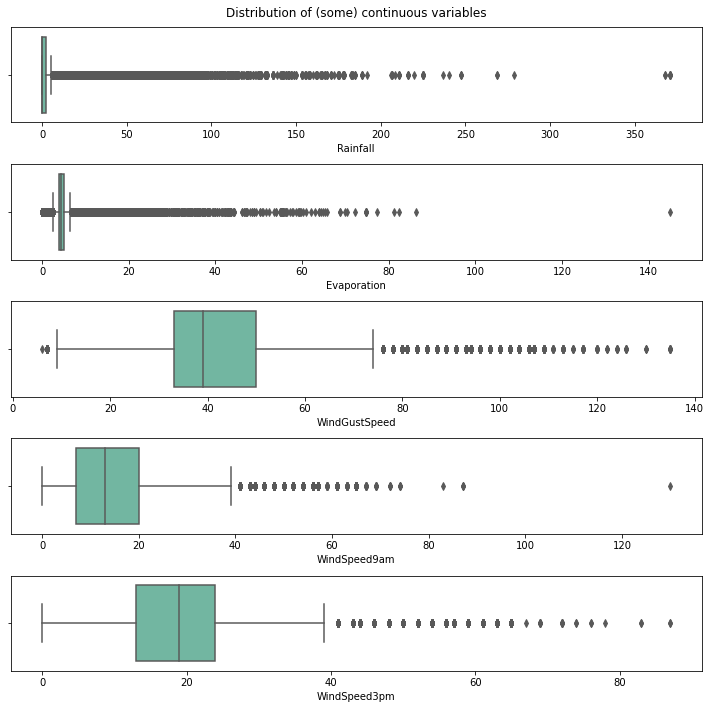

In [10]:
# IQR
var_data = weather_outliers.select_dtypes(include=['float64'])
var_data.describe().apply(round) # round the data to first decimal place

# boxplots to visualize outliers
fig, axes = plt.subplots(5,1, figsize=(10, 10), sharey=False)
fig.suptitle('Distribution of (some) continuous variables')

# Rainfall
sns.boxplot(x= 'Rainfall', data = weather_outliers, palette = 'Set2', ax = axes[0])
axes[0].set_title("")

# Evaporation
sns.boxplot(x= 'Evaporation', data =weather_outliers, palette = 'Set2', ax = axes[1])
axes[1].set_title("")

# WindGustSpeed
sns.boxplot(x= 'WindGustSpeed', data =weather_outliers, palette = 'Set2', ax = axes[2])
axes[3].set_title("")

# Windspeed (9AM)
sns.boxplot(x= 'WindSpeed9am', data = weather_outliers, palette = 'Set2', ax = axes[3])
axes[2].set_title("")

# Windspeed (3PM)
sns.boxplot(x= 'WindSpeed3pm', data =weather_outliers, palette = 'Set2', ax = axes[4])
axes[3].set_title("")

plt.tight_layout()

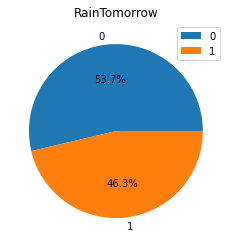

In [11]:
# RainTomorrow distribution in final dataset
data = [(weather['RainTomorrow'] == 0).sum(), (weather['RainTomorrow'] != 0).sum()]
lab = [0,1]
plt.pie(data, labels = lab, autopct='%1.1f%%')
plt.title('RainTomorrow')
plt.legend()
plt.show()

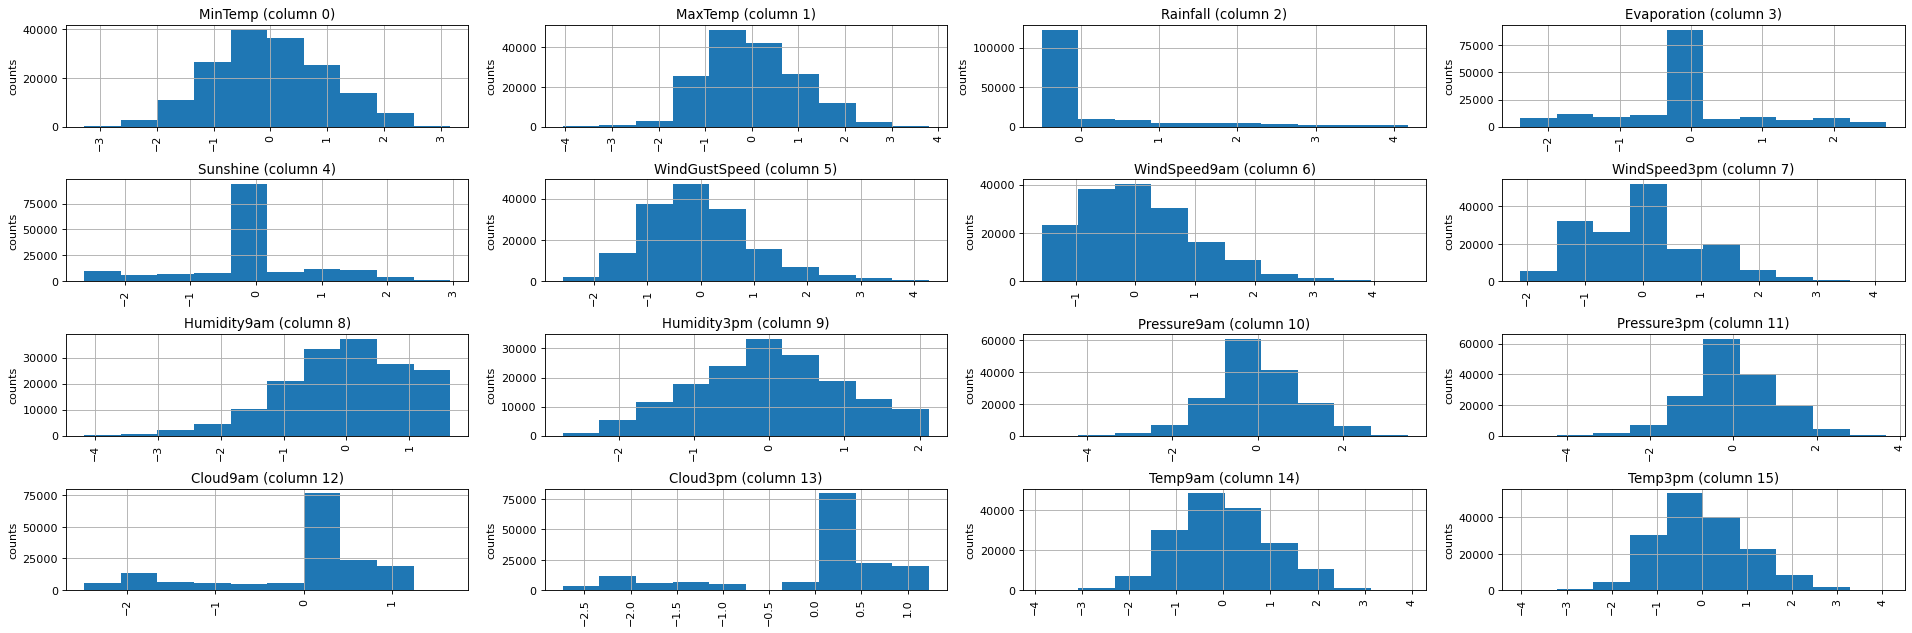

In [12]:
# data distributions
def plotDistribution(df, nGraphPerCol, nGraphPerRow):
    columnNames = list(df)
    nGraphRow = nGraphPerCol / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(df.shape[1]):
        plt.subplot(nGraphPerCol, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
weather_data = weather[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                        'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                        'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                        'Temp9am', 'Temp3pm']]

plotDistribution(weather_data, 4,4)

<AxesSubplot:>

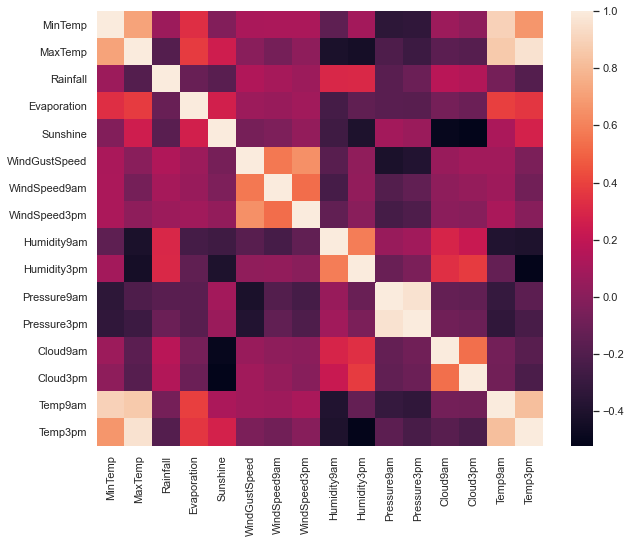

In [13]:
# Multicollinearity
sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(weather_data.corr())

In [6]:
# split data into train and test with 3:1 ratio 
from sklearn.model_selection import train_test_split
x_tr,x_te,y_tr,y_te = train_test_split(weather.drop("RainTomorrow", axis = 1),weather["RainTomorrow"],test_size=0.25,random_state = 0)

print(x_tr.shape)
print(y_tr.shape)
print(x_te.shape)
print(y_te.shape)

(121407, 117)
(121407,)
(40470, 117)
(40470,)


# Model Building

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import time

### Logistic Reg

In [8]:
# fit the logistic regression model
start = time.time()
lm_model = LogisticRegression(max_iter = 500, random_state = 0).fit(x_tr,y_tr)
print("running time of Logistic Regression:", time.time() - start)

running time of Logistic Regression: 3.5140867233276367


Accuracy of the Logistic on test: 0.7788485297751421
ROC score of the Logistic on test: 0.8607409980814262
--------------------------


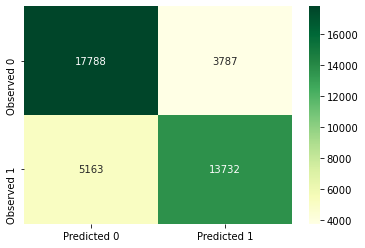

In [41]:
# make prediction based on test
pred_lm_te = lm_model.predict(x_te)
prob_lm_te = lm_model.predict_proba(x_te)[:,1]

# get the prediction accuracy
pa_lm = (pred_lm_te == y_te).mean()
print("Accuracy of the Logistic on test:",pa_lm)
# get the ROC score
roc_lm = roc_auc_score(y_te, prob_lm_te)
print("ROC score of the Logistic on test:", roc_lm)
# get the confusion matrix on test
cm_lm = (pd.DataFrame(confusion_matrix(y_te, pred_lm_te), 
                     columns = ["Predicted 0", "Predicted 1"],
                     index = ["Observed 0", "Observed 1"]))
sns.heatmap(cm_lm, annot = True, fmt = "d", cmap = "YlGn")


print("--------------------------")

# get the ROC curve
fpr_lm, tpr_lm, _ = roc_curve(y_te, prob_lm_te)


### Decision Tree

In [43]:
# fit the decision tree model
mydt = DecisionTreeClassifier().fit(x_tr,y_tr)

Accuracy of the Decision Tree on test: 0.9020509019026439
ROC score of Decision Tree on test: 0.8607409980814262
--------------------------


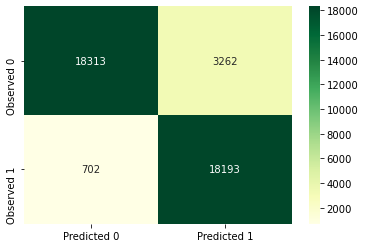

In [44]:
# make prediction based on test
pred_dt_te = mydt.predict(x_te)
prob_dt_te = mydt.predict_proba(x_te)[:,1]

# get the prediction accuracy
pa_dt = (pred_dt_te == y_te).mean()
print("Accuracy of the Decision Tree on test:",pa_dt)
# get the ROC score
roc_dt = roc_auc_score(y_te, prob_lm_te)
print("ROC score of Decision Tree on test:", roc_dt)
# get the confusion matrix on test
cm_dt = (pd.DataFrame(confusion_matrix(y_te, pred_dt_te), 
                     columns = ["Predicted 0", "Predicted 1"],
                     index = ["Observed 0", "Observed 1"]))
sns.heatmap(cm_dt, annot = True, fmt = "d", cmap = "YlGn")


print("--------------------------")

# get the ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_te, prob_dt_te)

### Random Forest

In [64]:
# fit the RF model
myrf = RandomForestClassifier().fit(x_tr, y_tr)

Accuracy of the Random Forest on test: 0.9472448727452434
ROC score of the Random Forest on test: 0.9887869273293866
--------------------------


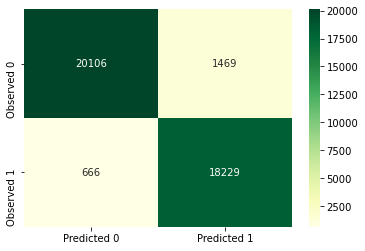

In [65]:
# make prediction based on test
pred_rf_te = myrf.predict(x_te)
prob_rf_te = myrf.predict_proba(x_te)[:,1]

# get the prediction accuracy
pa_rf = (pred_rf_te == y_te).mean()
print("Accuracy of the Random Forest on test:",pa_rf)
# get the ROC score
roc_rf = roc_auc_score(y_te, prob_rf_te)
print("ROC score of the Random Forest on test:", roc_rf)
# get the confusion matrix on test
cm_rf = (pd.DataFrame(confusion_matrix(y_te, pred_rf_te), 
                     columns = ["Predicted 0", "Predicted 1"],
                     index = ["Observed 0", "Observed 1"]))
sns.heatmap(cm_rf, annot = True, fmt = "d", cmap = "YlGn")


print("--------------------------")

# get the ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_te, prob_rf_te)

### KNN

In [91]:
# fit the KNN model
myknn = KNeighborsClassifier(weights = "distance").fit(x_tr, y_tr)

Accuracy of the KNN on test: 0.8272794662713121
ROC score of the KNN on test: 0.9072423299216841
--------------------------


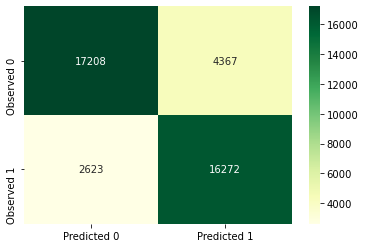

In [67]:
# make prediction based on test
pred_knn_te = myknn.predict(x_te)
prob_knn_te = myknn.predict_proba(x_te)[:,1]

# get the prediction accuracy
pa_knn = (pred_knn_te == y_te).mean()
print("Accuracy of the KNN on test:",pa_knn)
# get the ROC score
roc_knn = roc_auc_score(y_te, prob_knn_te)
print("ROC score of the KNN on test:", roc_knn)
# get the confusion matrix on test
cm_knn = (pd.DataFrame(confusion_matrix(y_te, pred_knn_te), 
                     columns = ["Predicted 0", "Predicted 1"],
                     index = ["Observed 0", "Observed 1"]))
sns.heatmap(cm_knn, annot = True, fmt = "d", cmap = "YlGn")


print("--------------------------")

# get the ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_te, prob_knn_te)


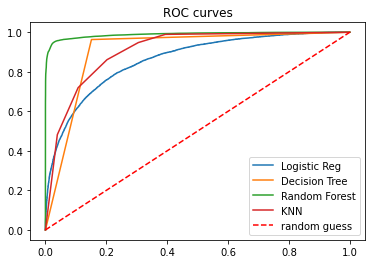

In [127]:
plt.plot(fpr_lm, tpr_lm, label = "Logistic Reg")
plt.plot(fpr_dt, tpr_dt, label = "Decision Tree")
plt.plot(fpr_rf, tpr_rf, label = "Random Forest")
plt.plot(fpr_knn, tpr_knn, label = "KNN")
plt.plot([0,1],[0,1], "r--", label = "random guess")
plt.title("ROC curves")
plt.legend(loc = "lower right")

# Hyperparameter Tuning

In [15]:
from sklearn.model_selection import GridSearchCV

### Logistic Reg

In [18]:
l_grid = {"C": [0.1,1,10], "solver": ["newton-cg","lbfgs","liblinear","sag","saga"]}
lm_grid = GridSearchCV(LogisticRegression(max_iter = 500), l_grid, scoring = "accuracy", refit = True, verbose = 1, cv = 3)
lm_grid.fit(x_tr,y_tr)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.6min finished


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=500, random_state=0),
             param_grid={'C': [0.1, 1, 10],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy', verbose=1)

{'C': 0.1, 'solver': 'newton-cg'}
Accuracy of the Logistic on test: 0.778650852483321
ROC score of the Logistic on test: 0.8606952540369922
--------------------------


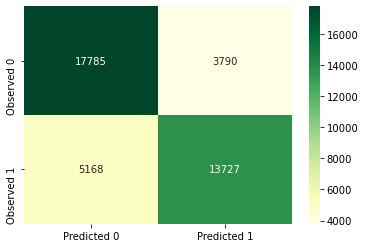

In [46]:
# show the best presets
print(lm_grid.best_params_)
# make new prediction based on test
pred_lm_g = lm_grid.predict(x_te)
prob_lm_g = lm_grid.predict_proba(x_te)[:,1]

# get the prediction accuracy
pa_lm_g = (pred_lm_g == y_te).mean()
print("Accuracy of the Logistic on test:",pa_lm_g)
# get the ROC score
roc_lm_g = roc_auc_score(y_te, prob_lm_g)
print("ROC score of the Logistic on test:", roc_lm_g)
# get the confusion matrix on test
cm_lm_g = (pd.DataFrame(confusion_matrix(y_te, pred_lm_g), 
                     columns = ["Predicted 0", "Predicted 1"],
                     index = ["Observed 0", "Observed 1"]))
sns.heatmap(cm_lm_g, annot = True, fmt = "d", cmap = "YlGn")


print("--------------------------")

# get the ROC curve
fpr_lm_g, tpr_lm_g, _ = roc_curve(y_te, prob_lm_g)

### Decision Tree

In [72]:
d_grid = {"criterion":["gini","entropy"],"max_features":["auto","log2"]}
# let grid search choose the best model
dt_grid = GridSearchCV(DecisionTreeClassifier(), d_grid, scoring = "accuracy", refit = True, verbose = 1, cv = 3)
dt_grid.fit(x_tr,y_tr)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.9s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'log2']},
             scoring='accuracy', verbose=1)

{'criterion': 'entropy', 'max_features': 'auto'}
Accuracy of the Decision Tree on test: 0.9024956758092414
ROC score of the Decision Tree on test: 0.906231305099199
--------------------------


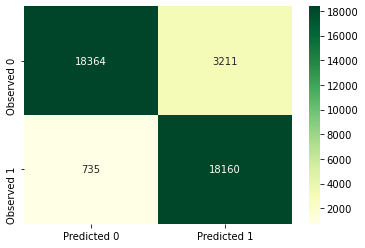

In [73]:
# show the best presets
print(dt_grid.best_params_)
# make new prediction based on test
pred_dt_g = dt_grid.predict(x_te)
prob_dt_g = dt_grid.predict_proba(x_te)[:,1]

# get the prediction accuracy
pa_dt_g = (pred_dt_g == y_te).mean()
print("Accuracy of the Decision Tree on test:",pa_dt_g)
# get the ROC score
roc_dt_g = roc_auc_score(y_te, prob_dt_g)
print("ROC score of the Decision Tree on test:", roc_dt_g)
# get the confusion matrix on test
cm_dt_g = (pd.DataFrame(confusion_matrix(y_te, pred_dt_g), 
                     columns = ["Predicted 0", "Predicted 1"],
                     index = ["Observed 0", "Observed 1"]))
sns.heatmap(cm_dt_g, annot = True, fmt = "d", cmap = "YlGn")


print("--------------------------")

# get the ROC curve
fpr_dt_g, tpr_dt_g, _ = roc_curve(y_te, prob_dt_g)

### Random Forest

In [74]:
r_grid = {"criterion":["gini","entropy"],"max_features":["sqrt","log2"]}
# let grid search choose the best model
rf_grid = GridSearchCV(RandomForestClassifier(), r_grid, scoring = "accuracy", refit = True, verbose = 1, cv = 3)
rf_grid.fit(x_tr,y_tr)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.0min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2']},
             scoring='accuracy', verbose=1)

{'criterion': 'entropy', 'max_features': 'log2'}
Accuracy of the Random Tree on test: 0.9477637756362738
ROC score of the Random Tree on test: 0.9891529618612587
--------------------------


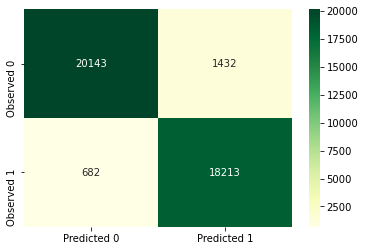

In [75]:
# show the best presets
print(rf_grid.best_params_)
# make new prediction based on test
pred_rf_g = rf_grid.predict(x_te)
prob_rf_g = rf_grid.predict_proba(x_te)[:,1]

# get the prediction accuracy
pa_rf_g = (pred_rf_g == y_te).mean()
print("Accuracy of the Random Tree on test:",pa_rf_g)
# get the ROC score
roc_rf_g = roc_auc_score(y_te, prob_rf_g)
print("ROC score of the Random Tree on test:", roc_rf_g)
# get the confusion matrix on test
cm_rf_g = (pd.DataFrame(confusion_matrix(y_te, pred_rf_g), 
                     columns = ["Predicted 0", "Predicted 1"],
                     index = ["Observed 0", "Observed 1"]))
sns.heatmap(cm_rf_g, annot = True, fmt = "d", cmap = "YlGn")


print("--------------------------")

# get the ROC curve
fpr_rf_g, tpr_rf_g, _ = roc_curve(y_te, prob_rf_g)

### KNN

In [96]:
k_grid = {"weights":["uniform"]}
# let grid search choose the best model
knn_grid = KNeighborsClassifier(weights = "distance", p = 1)
knn_grid.fit(x_tr,y_tr)

KNeighborsClassifier(p=1, weights='distance')

Accuracy of the KNN on test: 0.88295033358043
ROC score of the KNN on test: 0.9669539901087826
--------------------------


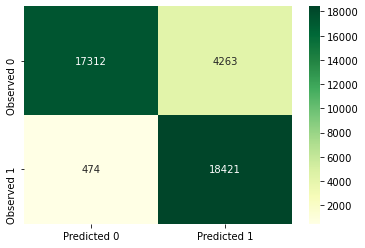

In [98]:
# show the best presets
#print(knn_grid.best_params_)
# make new prediction based on test
pred_knn_g = knn_grid.predict(x_te)
prob_knn_g = knn_grid.predict_proba(x_te)[:,1]

# get the prediction accuracy
pa_knn_g = (pred_knn_g == y_te).mean()
print("Accuracy of the KNN on test:",pa_knn_g)
# get the ROC score
roc_knn_g = roc_auc_score(y_te, prob_knn_g)
print("ROC score of the KNN on test:", roc_knn_g)
# get the confusion matrix on test
cm_knn_g = (pd.DataFrame(confusion_matrix(y_te, pred_knn_g), 
                     columns = ["Predicted 0", "Predicted 1"],
                     index = ["Observed 0", "Observed 1"]))
sns.heatmap(cm_knn_g, annot = True, fmt = "d", cmap = "YlGn")


print("--------------------------")

# get the ROC curve
fpr_knn_g, tpr_knn_g, _ = roc_curve(y_te, prob_knn_g)

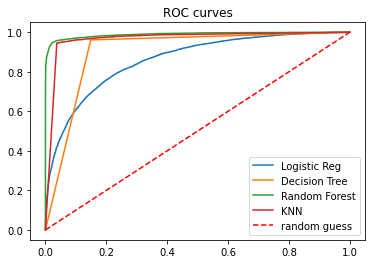

In [126]:
plt.plot(fpr_lm_g, tpr_lm_g, label = "Logistic Reg")
plt.plot(fpr_dt_g, tpr_dt_g, label = "Decision Tree")
plt.plot(fpr_rf_g, tpr_rf_g, label = "Random Forest")
plt.plot(fpr_knn_g, tpr_knn_g, label = "KNN")
plt.plot([0,1],[0,1], "r--", label = "random guess")
plt.title("ROC curves")
plt.legend(loc = "lower right")

# Time Evaluation

In [105]:
# use for loop to get 10 running times of each model
t_lm = np.zeros(10)
for i in range(10):
    start = time.time()
    tmodel = LogisticRegression(C = 0.1, solver = "newton-cg", max_iter = 500, random_state = i).fit(x_tr,y_tr)
    t_lm[i] = time.time() - start
    
t_dt = np.zeros(10)
for i in range(10):
    start = time.time()
    tmodel = DecisionTreeClassifier(criterion = "entropy", max_features = "auto", random_state = i).fit(x_tr,y_tr)
    t_dt[i] = time.time() - start
    
t_rf = np.zeros(10)
for i in range(10):
    start = time.time()
    tmodel = RandomForestClassifier(criterion = "entropy", max_features = "log2", random_state = i).fit(x_tr,y_tr)
    t_rf[i] = time.time() - start
    
t_knn = np.zeros(10)
for i in range(10):
    start = time.time()
    tmodel = KNeighborsClassifier(weights = "distance", p = 1).fit(x_tr,y_tr)
    t_knn[i] = time.time() - start

([<matplotlib.axis.XTick at 0x1db52c32880>,
 [Text(1, 0, 'Logistic Reg'),
  Text(2, 0, 'Decision Tree'),
  Text(3, 0, 'Random Forest'),
  Text(4, 0, 'KNN')])

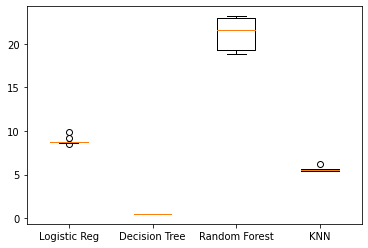

In [123]:
# plot the boxplot
time_result = {"Logistic Reg": t_lm, "Decision Tree": t_dt, "Random Forest": t_rf, "KNN": t_knn}
plt.boxplot(time_result.values())

plt.xticks([1,2,3,4],["Logistic Reg", "Decision Tree", "Random Forest", "KNN"])

In [21]:
# check the time and accuracy of different number of trees in Random Forest
n_tree = [10, 100, 200, 300, 400, 500]
time_rf = np.zeros(6)
acc_rf = np.zeros(6)
for i in range(len(n_tree)):
    start = time.time()
    rf = RandomForestClassifier(n_estimators = n_tree[i], max_depth = 20).fit(x_tr, y_tr)
    time_rf[i] = time.time() - start
    pred_rf = rf.predict(x_te)
    acc_rf[i] = (pred_rf == y_te).mean()

Text(0, 0.5, 'Prediciton accuracy')

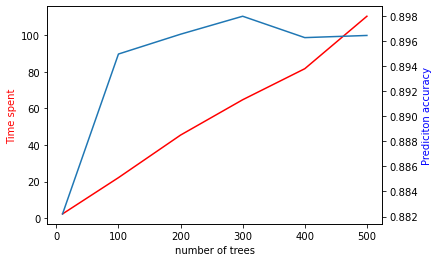

In [30]:
# make the plot
fig, ax = plt.subplots()
ax.plot(n_tree, time_rf, color = "r", label = "time")
ax.set_xlabel("number of trees")
ax.set_ylabel("Time spent", color = "r")
ax2 = ax.twinx()
ax2.plot(n_tree, acc_rf, label = "accuracy")
ax2.set_ylabel("Prediciton accuracy", color = "b")
